In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

from torchvision import datasets, models, transforms

In [2]:
def get_large_dataset(path, max_batch_idx = 100, shuffle = False, first_k = 5000):
    
    with open(path,'rb') as handle:
        data = pickle.load(handle)
    
    np_dataset_images  = np.expand_dims(data['images'],1)[:first_k]
    np_dataset_counts = data['no_count'].astype(np.int16)[:first_k]
    
    print(f'Images Dataset Shape: {np_dataset_images.shape}')
    
    for ii in range(1):
        iii = np_dataset_images[10 + ii].reshape((100, 100))
        plt.figure()
        plt.imshow(iii, cmap="gray")
  
    # create loader from the numpy tensors
    dataset_images, dataset_counts = map(torch.tensor, (np_dataset_images, np_dataset_counts))
    
    dataset_images = dataset_images.to(device)
    dataset_counts = dataset_counts.to(device)

    dataset = TensorDataset(dataset_images, dataset_counts)
    loader  = DataLoader(dataset,  batch_size = 64, shuffle = shuffle, drop_last = True)
    
    return loader

# Method 1: Without training on the counting dataset

- Will use a pretrained neural network on Mnist Dataset which will be later converted into a Fully Convolutional Network to be used on the Counting Dataset

# Convolutional Neural Network Architecture used for MNIST Dataset

In [3]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 30, kernel_size = 3, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 30, out_channels = 60, kernel_size = 2, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 60, out_channels = 100, kernel_size = 3, stride = 1)
        
        self.fc1 = nn.Linear(in_features = 2 * 2 * 100, out_features = 256)
        self.fc2 = nn.Linear(in_features = 256, out_features = 128)
        self.fc3 = nn.Linear(in_features = 128, out_features = 64)
        self.fc4 = nn.Linear(in_features = 64, out_features = 10)
        
    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.max_pool2d(x, 2, 2)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.max_pool2d(x, 2, 2)
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = F.max_pool2d(x, 2, 2)
        #print(x.shape)
        
        x = x.view(-1, 2 * 2 * 100)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        x = self.fc4(x)
        
        return x

# Fully Convolutional Neural Network used for the Counting Digits Dataset

In [4]:
class FullyConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 30, kernel_size = 3, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 30, out_channels = 60, kernel_size = 2, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 60, out_channels = 100, kernel_size = 3, stride = 1)
        
        self.fully_conv1 = nn.Conv2d(in_channels = 100, out_channels = 256, kernel_size = 2, stride = 1)
        self.fully_conv2 = nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 1, stride = 1)
        self.fully_conv3 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 1)
        self.fully_conv4 = nn.Conv2d(in_channels = 64, out_channels = 10, kernel_size = 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.fully_conv1(x))
        x = F.relu(self.fully_conv2(x))
        x = F.relu(self.fully_conv3(x))
        x = self.fully_conv4(x)
        
        return F.log_softmax(x, dim=1)

# Alright, let's begin:
- Load and train a convolutional neural network for digit recognition on MNIST Dataset

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mnist_data_train = datasets.MNIST("../data", train = True, transform = transforms.Compose([transforms.ToTensor()]))
mnist_data_test  = datasets.MNIST("../data", train = False, transform = transforms.Compose([transforms.ToTensor()]))

trainloader = DataLoader(mnist_data_train, batch_size = 64, shuffle = True, num_workers = 4, drop_last = True)
testloader  = DataLoader(mnist_data_test, batch_size = 64, shuffle = True, num_workers = 4, drop_last = True)

In [6]:
model = ConvolutionalNeuralNetwork().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
epochs = 15

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output, labels)
        
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
        
    else:
        
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            for images, labels in testloader:

                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                test_loss += criterion(output, labels)

                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/15..  Training Loss: 0.305..  Test Loss: 0.085..  Test Accuracy: 0.973
Epoch: 2/15..  Training Loss: 0.064..  Test Loss: 0.036..  Test Accuracy: 0.989
Epoch: 3/15..  Training Loss: 0.044..  Test Loss: 0.034..  Test Accuracy: 0.990
Epoch: 4/15..  Training Loss: 0.035..  Test Loss: 0.039..  Test Accuracy: 0.988
Epoch: 5/15..  Training Loss: 0.030..  Test Loss: 0.034..  Test Accuracy: 0.989
Epoch: 6/15..  Training Loss: 0.025..  Test Loss: 0.034..  Test Accuracy: 0.991
Epoch: 7/15..  Training Loss: 0.021..  Test Loss: 0.037..  Test Accuracy: 0.990
Epoch: 8/15..  Training Loss: 0.019..  Test Loss: 0.051..  Test Accuracy: 0.986
Epoch: 9/15..  Training Loss: 0.018..  Test Loss: 0.034..  Test Accuracy: 0.992
Epoch: 10/15..  Training Loss: 0.013..  Test Loss: 0.040..  Test Accuracy: 0.991
Epoch: 11/15..  Training Loss: 0.015..  Test Loss: 0.035..  Test Accuracy: 0.991
Epoch: 12/15..  Training Loss: 0.012..  Test Loss: 0.029..  Test Accuracy: 0.992
Epoch: 13/15..  Training Loss: 0.010.

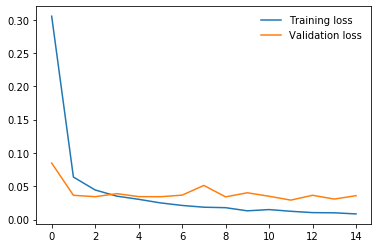

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Loading the Counting Dataset

Images Dataset Shape: (5000, 1, 100, 100)
Images Dataset Shape: (1000, 1, 100, 100)


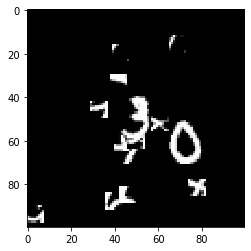

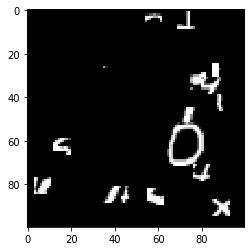

In [8]:
trainloader = get_large_dataset(path = "mnist_count_train.pickle", max_batch_idx = 50, shuffle = True)
testloader  = get_large_dataset(path = "mnist_count_test.pickle", max_batch_idx = 50)

# Saving the classification network trained on MNIST

In [9]:
# PATH = 'classification_net.pt'
# torch.save(model.state_dict(), PATH)

# Converting a Convolutional Neural Network with fully connected layers into a Fully Convolutional Network
 For that will load the weights of the recognition network trained earlier and then:
- The convolutional layers will remain the same
- For the first fully connected layer will convert the 400 neurons in 100 kernels of shape (2, 2)
- For the rest fully connected layers with "n" neurons each will convert them in "n" kernels of shape (1, 1)

After the weights are reshaped, we can load them into the fully convolutional network

In [10]:
localisation_model = FullyConvolutionalNeuralNetwork()

# for param_tensor in localisation_model.state_dict():
#     print(param_tensor, "\t", localisation_model.state_dict()[param_tensor].size())

loaded_state_dict = torch.load(PATH)

print("-------------- Initial Weights Shape --------------")
for key, val in loaded_state_dict.items():
    print(val.shape)

model_dict = {}
for key, val in loaded_state_dict.items():
    key = key.replace('fc','fully_conv')
    if 'fully_conv1.weight' in key:
        val = val.view(-1, 100, 2, 2)
    if 'fully_conv2.weigh' in key:
        val = val.view(-1, 256, 1, 1)
    if 'fully_conv3.weigh' in key:
        val = val.view(-1, 128, 1, 1)
    if 'fully_conv4.weigh' in key:
        val = val.view(-1, 64, 1, 1)
    model_dict[key] = val
    
print("-------------- After Reshaping --------------")
for key, val in model_dict.items():
    print(val.shape) 
    
localisation_model.load_state_dict(model_dict)
localisation_model.to(device)

-------------- Initial Weights Shape --------------
torch.Size([30, 1, 3, 3])
torch.Size([30])
torch.Size([60, 30, 2, 2])
torch.Size([60])
torch.Size([100, 60, 3, 3])
torch.Size([100])
torch.Size([256, 400])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
-------------- After Reshaping --------------
torch.Size([30, 1, 3, 3])
torch.Size([30])
torch.Size([60, 30, 2, 2])
torch.Size([60])
torch.Size([100, 60, 3, 3])
torch.Size([100])
torch.Size([256, 100, 2, 2])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([64, 128, 1, 1])
torch.Size([64])
torch.Size([10, 64, 1, 1])
torch.Size([10])


FullyConvolutionalNeuralNetwork(
  (conv1): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(30, 60, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(60, 100, kernel_size=(3, 3), stride=(1, 1))
  (fully_conv1): Conv2d(100, 256, kernel_size=(2, 2), stride=(1, 1))
  (fully_conv2): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (fully_conv3): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (fully_conv4): Conv2d(64, 10, kernel_size=(1, 1), stride=(1, 1))
)

# Finding the right threshold on the trainset
- Usually we search thresholds and hyperparameters on the validation set, but taking into consideration the fact that this network has not seen the training set and does not need to be trained, we can use this one instead
- More explanations in comments

In [11]:
criterion = nn.MSELoss()
best_threshold = 0
best_accuracy  = 0 

for threshold in np.arange(0.999, 1, 0.0001):
    print("Threshold: ", threshold)
    accuracy = 0
    total_error = 0
    how_many_images = 0
    for idx, (images, labels) in enumerate(trainloader):
        
        images = images.float() / 255.0
        images = images.to(device)
        labels = labels.to(device)
        
        #Get the output (shape -> (64, 10, 10, 10))
        output = localisation_model(images)
        
        # Log to normal probabilities (64 - images, (10) - class, (10, 10) - kernels)
        output = torch.exp(output)
        output = output.view(64, 10, -1)
        
        # Each image will have in each kernel the max probability of that kernel being a digit between 0 - 9 (dim = 1 of the tensor)
        # print(output[0].shape)
        
        # Take the maxim probability in each kernel 
        check_if_over_thres, _ = torch.max(output, dim = 2)
        
        # Get first 5 probabilities
        probs, _ = torch.sort(check_if_over_thres, dim=1, descending=True)
        probs    = probs[:, 0:5]
        
        count = (probs > threshold).sum(dim=1).float()
        
        if idx == 0:
            print("Predicted number of digits in image")
            print(count)
            print("Real number of digits in image")
            print(labels)
        
        actual_error = criterion(count, labels)
        total_error = total_error + actual_error
        accuracy = accuracy + torch.sum(labels == count)
        how_many_images = how_many_images + images.shape[0]

        
    total_accuracy = accuracy.float() * 100 / how_many_images
    
    print("For Threshold {}, Accuracy: {}".format(threshold, total_accuracy))
    
    if total_accuracy > best_accuracy:
        best_accuracy = total_accuracy
        best_threshold = threshold
        
print("Best Accuracy: ", best_accuracy)
print("Best Threshold: ", best_threshold)

Threshold:  0.999
Predicted number of digits in image
tensor([5., 3., 5., 4., 3., 4., 3., 5., 5., 5., 5., 5., 2., 5., 5., 5., 4., 4.,
        4., 5., 5., 5., 3., 5., 5., 3., 5., 5., 5., 4., 5., 5., 5., 5., 4., 5.,
        3., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 4., 4., 4., 5., 3.,
        5., 5., 5., 4., 5., 5., 4., 5., 5., 5.], device='cuda:0')
Real number of digits in image
tensor([5, 1, 4, 4, 2, 2, 1, 4, 5, 3, 1, 3, 3, 3, 4, 5, 1, 1, 3, 5, 2, 5, 1, 5,
        5, 1, 3, 4, 5, 1, 5, 4, 4, 5, 1, 4, 2, 2, 3, 4, 2, 4, 2, 2, 5, 1, 5, 4,
        2, 3, 3, 5, 5, 3, 1, 5, 4, 1, 4, 5, 1, 5, 1, 4], device='cuda:0',
       dtype=torch.int16)
For Threshold 0.999, Accuracy: 24.118589401245117
Threshold:  0.9991
Predicted number of digits in image
tensor([3., 4., 2., 5., 2., 5., 5., 4., 5., 4., 4., 5., 1., 5., 1., 3., 5., 5.,
        4., 5., 4., 5., 5., 3., 4., 4., 5., 2., 3., 5., 5., 5., 5., 5., 4., 4.,
        5., 3., 5., 5., 4., 4., 4., 5., 4., 5., 4., 3., 5., 4., 4., 4., 4., 5.,
    

# Testing the model on the validation set using the best threshold

In [12]:
accuracy = 0
total_error = 0
how_many_images = 0
for idx, (images, labels) in enumerate(testloader):

    images = images.float() / 255.0
    images = images.to(device)
    labels = labels.to(device)

    #Get the output (shape -> (64, 10, 10, 10))
    output = localisation_model(images)

    # Log to normal probabilities (64 - images, (10) - class, (10, 10) - kernels)
    output = torch.exp(output)
    output = output.view(64, 10, -1)

    # Each image will have in each kernel the max probability of that kernel being a digit between 0 - 9 (dim = 1 of the tensor)
    # print(output[0].shape)

    # Take the maxim probability in each kernel 
    check_if_over_thres, _ = torch.max(output, dim = 2)

    # Get first 5 probabilities
    probs, _ = torch.sort(check_if_over_thres, dim=1, descending=True)
    probs    = probs[:, 0:5]

    count = (probs > best_threshold).sum(dim=1).float()

    if idx == 0:
        print("Predicted number of digits in image")
        print(count)
        print("Real number of digits in image")
        print(labels)

    actual_error = criterion(count, labels)
    total_error = total_error + actual_error
    accuracy = accuracy + torch.sum(labels == count)
    how_many_images = how_many_images + images.shape[0]


total_accuracy = accuracy.float() * 100 / how_many_images


print("Accuracy on test set:", total_accuracy.item())

Predicted number of digits in image
tensor([2., 2., 2., 3., 5., 2., 3., 4., 3., 1., 2., 5., 3., 5., 3., 1., 1., 4.,
        2., 4., 2., 5., 3., 0., 4., 4., 5., 3., 1., 3., 5., 2., 3., 5., 2., 5.,
        1., 5., 3., 3., 2., 2., 3., 3., 2., 3., 5., 2., 0., 4., 1., 2., 3., 3.,
        4., 3., 3., 2., 2., 3., 1., 1., 2., 1.], device='cuda:0')
Real number of digits in image
tensor([3, 2, 1, 4, 3, 3, 4, 5, 1, 1, 1, 5, 4, 5, 2, 4, 1, 3, 5, 3, 3, 2, 2, 1,
        5, 4, 5, 3, 2, 1, 4, 1, 4, 3, 2, 5, 1, 5, 2, 3, 1, 2, 3, 1, 1, 4, 5, 2,
        2, 5, 2, 1, 3, 4, 4, 3, 2, 3, 1, 5, 3, 1, 3, 1], device='cuda:0',
       dtype=torch.int16)
Accuracy on test set: 33.020835876464844


# As you can see the results are quite disappointing
- Taking into consideration that the random chance is 20% (1 / 5), this performes slightly better but still not enough

- There are many reasons for this result:

1) The nature of the problem it's not the same between the models, because in the first model the 28x28 images contain the digit in the center of the image, if we slide a window of 28x28 or use a fully convolutional network over the 100x100 images it's not guaranteed that patch contains a full digit or enough of it to be recognized

(For this we can try a scale factor for the 100x100 image, or of course kernels with different sizes and different strides but those will be computationally expensive, or we can train the initial recognition network with augumentations like: cutout augumentation, grid distortion or affine transformations)

2) The essential difference between a convolutional layer and a fully connected layer

"Conv layers therefore are well suited to detect local features that may appear anywhere in the input"

"FC layers are used to detect specific global configurations of the features detected by the lower layers in the net"

Which may explain why converting a fully connected layer into a convolutional layer may not bring good results

A short answear from here explains better:
https://stats.stackexchange.com/questions/312838/difference-between-conv-and-fc-layers

3) And of course the fact that a convolution layer is learnig a 2-dimensional kernel to be applied over a tensor which will take in consideration for the upper and lower neighbor of a pixel in the image, but a fully connected layer does not consider that

- Will see if we can get better results in the second part

# Method 2: Train a new convolutional network from scratch to predict the number of digits 

# The final version and failed trials
- Unfortunately here is only the final version of the architecture because it was only a single model that changed over time

# But here are 5 things that did not work for this problem:
- Trying to solve this as a regression problem, using a MSE loss function, but after choosing a threshold the accuracy score was not impressive
- Adding multiple fully connected layers resulted to a overfit problem
- Adding more convolutional layers was to much for my GPU
- Using different kernels sizes and strides
- 2-D Batch Normalization

# Things to be used in the future
- Adding Droupout for regularization to allow bigger networks
- Adding Augumentation for images

In [13]:
class CountingConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size = 5, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 40, out_channels = 60, kernel_size = 5, stride = 1)
        
#         self.bn1 = nn.BatchNorm2d(20)
#         self.bn2 = nn.BatchNorm2d(40)
#         self.bn3 = nn.BatchNorm2d(60)
        
        self.fc1 = nn.Linear(9 * 9 * 60, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 6)
        
    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.max_pool2d(x, 2, 2)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.max_pool2d(x, 2, 2)
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = F.max_pool2d(x, 2, 2)
        #print(x.shape)
    
        x = x.view(-1, 9 * 9 * 60)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        x = self.fc4(x)
        
        return x

In [14]:
model = CountingConvolutionalNetwork().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.01)
criterion = nn.CrossEntropyLoss()
epochs = 100

train_losses, test_losses, accuracies = [], [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        model.train()
        
        images = images.float() / 255.0
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output, labels.long())
        
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
        
    else:
        
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            for images, labels in testloader:
                
                model.eval()
                
                images = images.float() / 255.0
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                test_loss += criterion(output, labels.long())

                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracies.append(accuracy)
        

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/100..  Training Loss: 1.663..  Test Loss: 1.610..  Test Accuracy: 0.199
Epoch: 2/100..  Training Loss: 1.609..  Test Loss: 1.597..  Test Accuracy: 0.181
Epoch: 3/100..  Training Loss: 1.578..  Test Loss: 1.543..  Test Accuracy: 0.265
Epoch: 4/100..  Training Loss: 1.514..  Test Loss: 1.287..  Test Accuracy: 0.419
Epoch: 5/100..  Training Loss: 1.249..  Test Loss: 1.249..  Test Accuracy: 0.418
Epoch: 6/100..  Training Loss: 1.149..  Test Loss: 1.117..  Test Accuracy: 0.501
Epoch: 7/100..  Training Loss: 1.057..  Test Loss: 1.032..  Test Accuracy: 0.517
Epoch: 8/100..  Training Loss: 0.992..  Test Loss: 0.977..  Test Accuracy: 0.562
Epoch: 9/100..  Training Loss: 0.891..  Test Loss: 0.774..  Test Accuracy: 0.657
Epoch: 10/100..  Training Loss: 0.800..  Test Loss: 0.775..  Test Accuracy: 0.652
Epoch: 11/100..  Training Loss: 0.749..  Test Loss: 0.695..  Test Accuracy: 0.714
Epoch: 12/100..  Training Loss: 0.682..  Test Loss: 0.675..  Test Accuracy: 0.694
Epoch: 13/100..  Training

# Plotting the train and test losses and the evolution of accuracy

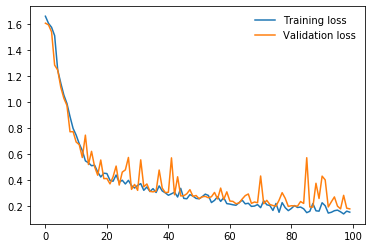

In [17]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

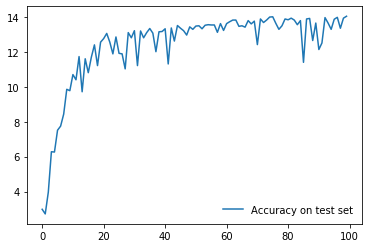

In [18]:
plt.plot(accuracies, label='Accuracy on test set')
plt.legend(frameon=False)
plt.show()